# IOOS QARTOD software (ioos_qc)

This post will demonstrate how to [run ``ioos_qc``](https://github.com/ioos/ioos_qc) on a time-series dataset. ``ioos_qc`` implements the [Quality Assurance / Quality Control of Real Time Oceanographic Data (QARTOD)](https://ioos.noaa.gov/project/qartod/).

We will [use `bokeh`](https://docs.bokeh.org/en/latest/) for interactive plots, so let's start by loading the interactive notebook output.

In [1]:
from bokeh.plotting import output_notebook
output_notebook()

ModuleNotFoundError: No module named 'bokeh'

We will be using the water level data from a [fixed station in Kotzebue, AK](https://www.google.com/maps?q=66.895035,-162.566752).

Below we create a simple Quality Assurance/Quality Control (QA/QC) configuration that will be used as input for ``ioos_qc``. All the interval values are in the same units as the data.

For more information on the tests and recommended values for QA/QC check the documentation of each test and its inputs: 
https://ioos.github.io/ioos_qc/api/ioos_qc.html#module-ioos_qc.qartod

In [2]:
variable_name = "sea_surface_height_above_sea_level_geoid_mhhw"


qc_config = {
    "qartod": {
      "gross_range_test": {
        "fail_span": [-10, 10],
        "suspect_span": [-2, 3]
      },
      "flat_line_test": {
        "tolerance": 0.001,
        "suspect_threshold": 10800,
        "fail_threshold": 21600
      },
      "spike_test": {
        "suspect_threshold": 0.8,
        "fail_threshold": 3,
      }
    }
}

Now we are ready to load the data, run tests and plot results!

We will get the data from the [AOOS ERDDAP server](http://erddap.aoos.org/erddap/). Note that the data may change in the future. For reproducibility's sake we will save the data downloaded into a CSV file.

In [3]:
from pathlib import Path
import pandas as pd
from erddapy import ERDDAP


path = Path().absolute()
fname = path.joinpath("data", "water_level_example.csv")

if fname.is_file():
    data = pd.read_csv(fname, parse_dates=["time (UTC)"])
else:
    e = ERDDAP(
        server="http://erddap.aoos.org/erddap/",
        protocol="tabledap"
    )
    e.dataset_id = "kotzebue-alaska-water-level"
    e.constraints = {
        "time>=": "2018-09-05T21:00:00Z",
        "time<=": "2019-07-10T19:00:00Z",
    }
    e.variables = [
        variable_name,
        "time",
        "z",
    ]
    data = e.to_pandas(
        index_col="time (UTC)",
        parse_dates=True,
    )
    data["timestamp"] = data.index.astype("int64") // 1e9
    data.to_csv(fname)

data.head()

,time (UTC),sea_surface_height_above_sea_level_geoid_mhhw (m),z (m),timestamp
0,2018-09-05 21:00:00+00:00,0.4785,0.0,1.536181e+09
1,2018-09-05 22:00:00+00:00,0.4420,0.0,1.536185e+09
2,2018-09-05 23:00:00+00:00,0.4968,0.0,1.536188e+09
3,2018-09-06 01:00:00+00:00,0.5456,0.0,1.536196e+09
4,2018-09-06 02:00:00+00:00,0.5761,0.0,1.536199e+09


In [4]:
from ioos_qc.config import QcConfig


qc = QcConfig(qc_config)

qc_results =  qc.run(
    inp=data["sea_surface_height_above_sea_level_geoid_mhhw (m)"],
    tinp=data["timestamp"],
    zinp=data["z (m)"],
    gen_agg=True
)

qc_results

OrderedDict([('qartod',
              OrderedDict([('gross_range_test',
                            masked_array(data=[1, 1, 1, ..., 1, 1, 1],
                                         mask=False,
                                   fill_value=999999,
                                        dtype=uint8)),
                           ('flat_line_test', array([1, 1, 1, ..., 1, 1, 1])),
                           ('spike_test',
                            masked_array(data=[1, 1, 1, ..., 1, 1, 1],
                                         mask=False,
                                   fill_value=999999,
                                        dtype=uint8))]))])

The results are returned in a dictionary format, similar to the input configuration, with a mask for each test. While the mask **is** a masked array it should not be applied as such. The results range from 1 to 4 meaning:

1. data passed the QA/QC
2. did not run on this data point
3. flag as suspect
4. flag as failed

Now we can write a plotting function that will read these results and flag the data.

In [5]:
%matplotlib inline

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt



def plot_results(data, var_name, results, title, test_name):
    time = data["time (UTC)"]
    obs = data[var_name]
    qc_test = results["qartod"][test_name]

    qc_pass = np.ma.masked_where(qc_test != 1, obs)
    qc_suspect = np.ma.masked_where(qc_test != 3, obs)
    qc_fail = np.ma.masked_where(qc_test != 4, obs)
    qc_notrun = np.ma.masked_where(qc_test != 2, obs)

    fig, ax = plt.subplots(figsize=(15, 3.75))
    fig.set_title = f"{test_name}: {title}"
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Observation Value")

    kw = {"marker": "o", "linestyle": "none"}
    ax.plot(time, obs,  label="obs", color="#A6CEE3")
    ax.plot(time, qc_notrun, markersize=2, label="qc not run", color="gray", alpha=0.2, **kw)
    ax.plot(time, qc_pass, markersize=4, label="qc pass", color="green", alpha=0.5, **kw)
    ax.plot(time, qc_suspect, markersize=4, label="qc suspect", color="orange", alpha=0.7, **kw)
    ax.plot(time, qc_fail, markersize=6, label="qc fail", color="red", alpha=1.0, **kw)
    ax.grid(True)


title = "Water Level [MHHW] [m] : Kotzebue, AK"

The gross range test test should fail data outside the $\pm$ 10 range and suspect data below -2, and greater than 3. As one can easily see all the major spikes are flagged as expected.

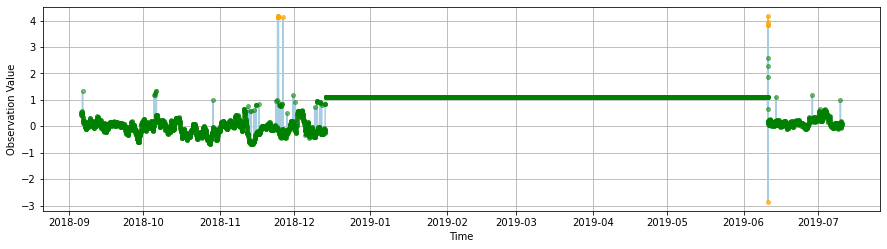

In [6]:
plot_results(
    data,
    "sea_surface_height_above_sea_level_geoid_mhhw (m)",
    qc_results,
    title,
    "gross_range_test"
)

An actual spike test, based on a data increase threshold, flags similar spikes to the gross range test but also indetifies other suspect unusual increases in the series.

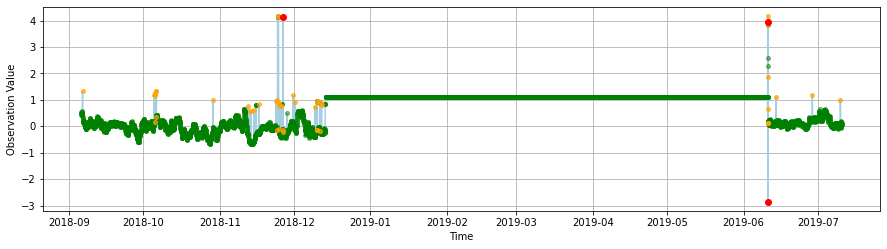

In [7]:
plot_results(
    data,
    "sea_surface_height_above_sea_level_geoid_mhhw (m)",
    qc_results,
    title,
    "spike_test"
)

The flat line test identifies issues with the data where values are "stuck."

`ioos_qc` succefully identified a huge portion of the data where that happens and flagged a smaller one as suspect. (Zoom in the red point to the left to see this one.)

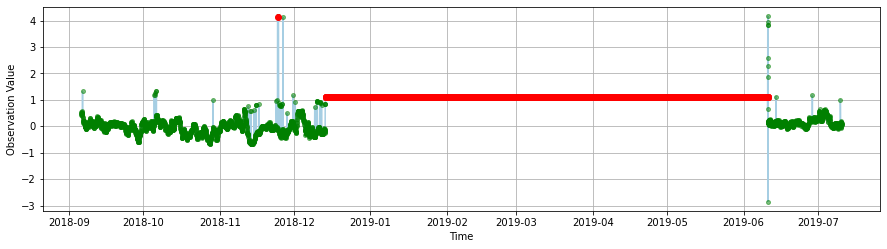

In [8]:
plot_results(
    data,
    "sea_surface_height_above_sea_level_geoid_mhhw (m)",
    qc_results,
    title,
    "flat_line_test"
)

This notebook was adapt from Jessica Austin and Kyle Wilcox's [original ioos_qc examples](https://github.com/ioos/ioos_qc/blob/b34b3762d659362fb3af11f52d8905d18cd6ec7b/docs/source/examples/QartodTestExample_WaterLevel.ipynb). Please [see the ``ioos_qc`` documentation](https://ioos.github.io/ioos_qc/) for more examples.